In [1]:
# Load Libraries
import pandas as pd 
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from gensim.models import Word2Vec
from numpy import asarray
from numpy import zeros
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.tokenize import RegexpTokenizer
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
# general imports
import math
from bs4 import BeautifulSoup
import tensorflow as tf
import numpy as np
import skimage
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
import missingno as msno


Load data

In [2]:
df = pd.read_csv('../input/amazon-alexa-reviews/amazon_alexa.tsv', sep='\t')

check Shape

In [3]:
df.shape

(3150, 5)

First Look at data

In [4]:

df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


Describe Data

In [5]:
df.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [6]:
#Duplicate Analysis
cols=df.columns
#print(list(cols))
dups_df = df.pivot_table(index=list(cols), aggfunc='size')
print (dups_df)

rating  date       variation    verified_reviews                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        feedback
1       1-Jul-18   White        This item did not work. Certified refurbished should mean it works as advertised. Instead this item crashed as soon as I turned it on and plugged it in. When trying to connect from my phone to the echo dot, it crashed, over and over. Not only would it disconnect but the orange light would freeze and then the thing would reboot with the blue 

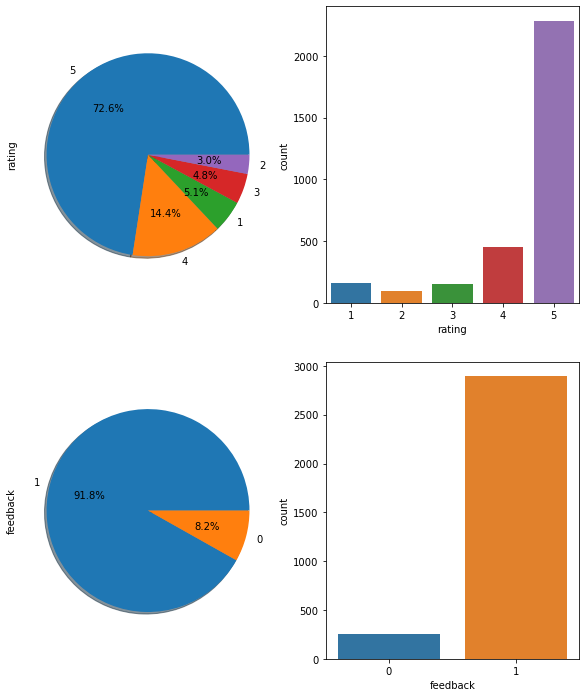

In [7]:
#Explore Categorical Variables
cat_col = ['rating','feedback']

plt.figure(figsize=(10, 12))
count = 1
for cols in cat_col:
    plt.subplot(2, 2, count)
    df[cols].value_counts().plot.pie(shadow=True,autopct='%1.1f%%')
    count +=1
    plt.subplot(2, 2, count)
    sns.countplot(cols, data=df)
    count+=1

* rating : 72.6% (max) belongs to 5 , 3% (lowest) belongs to 2
  It gives an impression that people are really happy with Alexa  

* feedback : 91.8% gave feedback, 8.2% ddi not give feedback


No duplicates present

In [8]:
# Find missing values
print("Colums with Null values: \n",df.isnull().sum())

Colums with Null values: 
 rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64


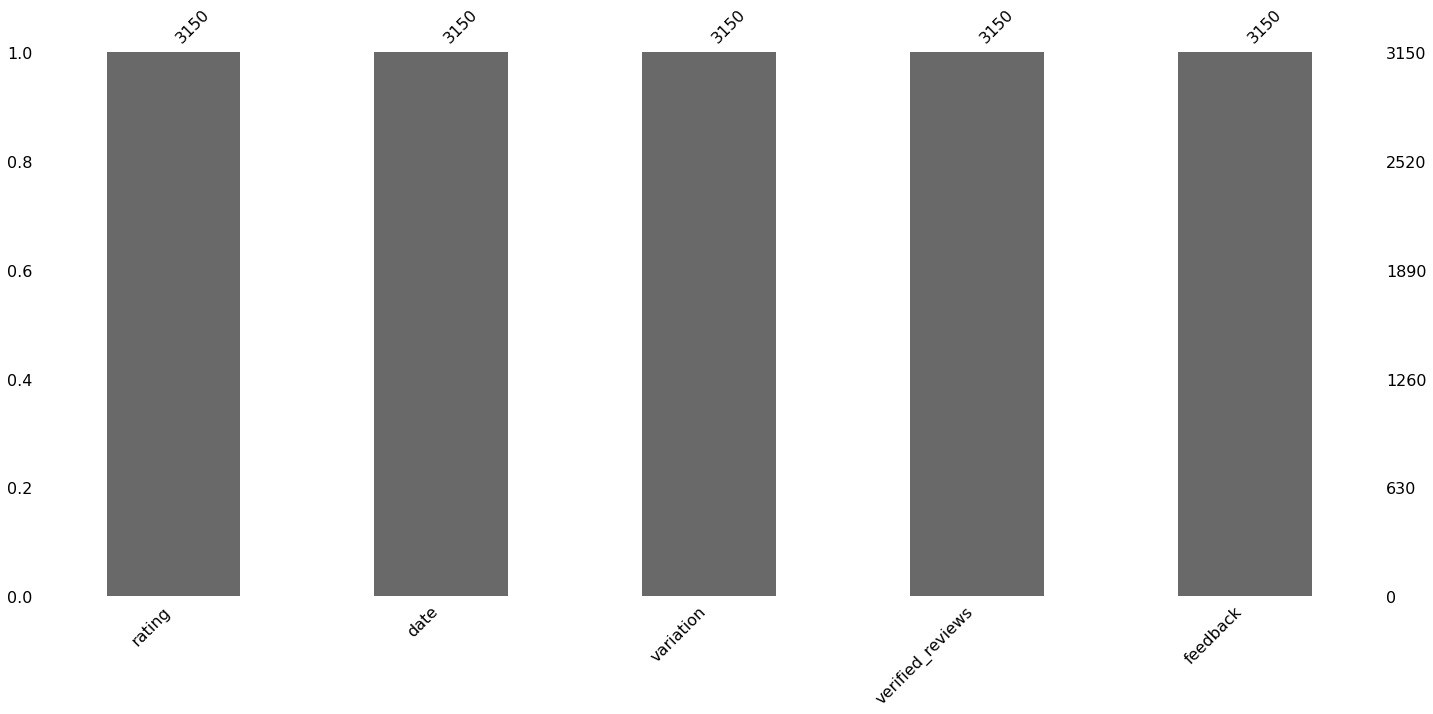

In [9]:
msno.bar(df)

Explore Numerical Data

In [10]:
#Variable - variation
#Find unique variation
len(df['variation'].unique())

16

Total 16 unique variation

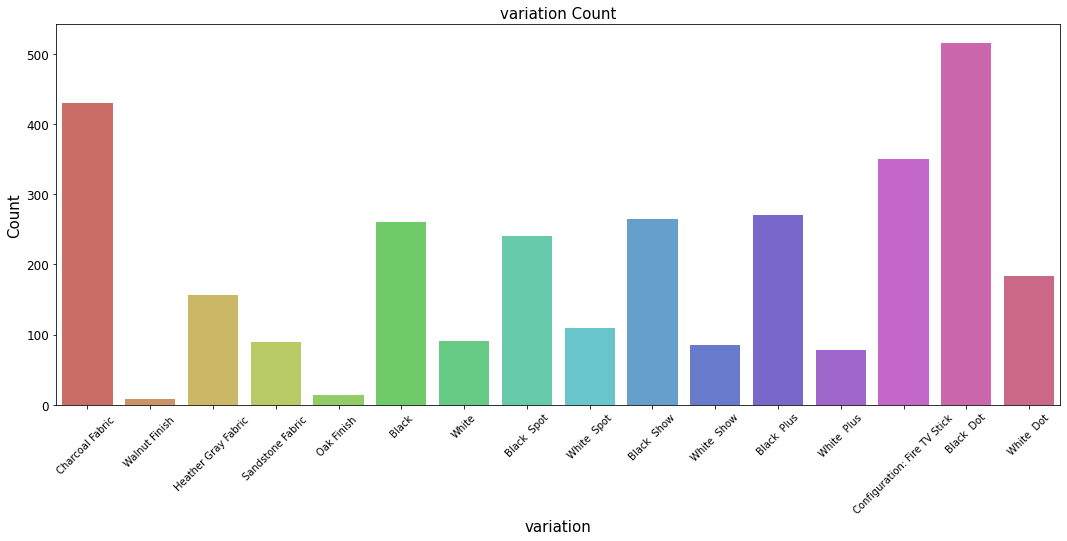

In [11]:
#Plotting Variation
plt.figure(figsize=(18,7))
sns.countplot(x='variation', data=df, palette="hls")
plt.xlabel("variation", fontsize=15) #seting the xtitle and size
plt.ylabel("Count", fontsize=15) # Seting the ytitle and size
plt.title("variation Count", fontsize=15) 
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.xticks(rotation=45)
plt.show()

Black dot is highest Vs Walnut finish is lowest 

Date , Month and weekday Analysis

In [12]:
#Variable - date
#Find unique dates 
len(df['date'].unique())

77

Total 77 unique dates

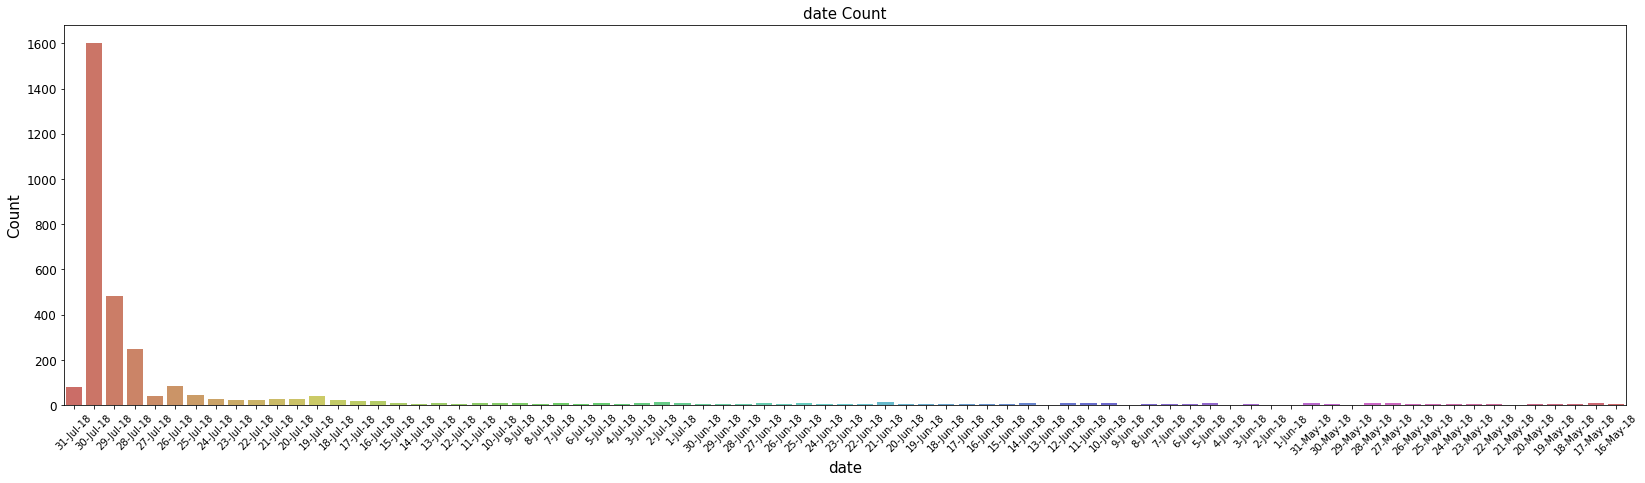

In [13]:
#Plotting date
plt.figure(figsize=(28,7))
sns.countplot(x='date', data=df, palette="hls")
plt.xlabel("date", fontsize=15) #seting the xtitle and size
plt.ylabel("Count", fontsize=15) # Seting the ytitle and size
plt.title("date Count", fontsize=15) 
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.xticks(rotation=45)
plt.show()


Lets see top 10 Dates by frequency

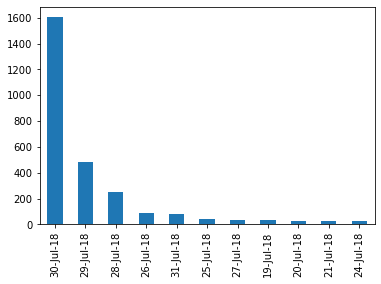

In [14]:
df_date_top10 = pd.DataFrame(df['date'].value_counts()[0:11])
df_date_top10.date.plot.bar()

30th, 29th & 28th July have maximum frequency

In [15]:
df['month'] = pd.DatetimeIndex(df['date']).month
df['weekday'] = pd.DatetimeIndex(df['date']).weekday
df.head()

,rating,date,variation,verified_reviews,feedback,month,weekday
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,7,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,7,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,7,1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,7,1
4,5,31-Jul-18,Charcoal Fabric,Music,1,7,1


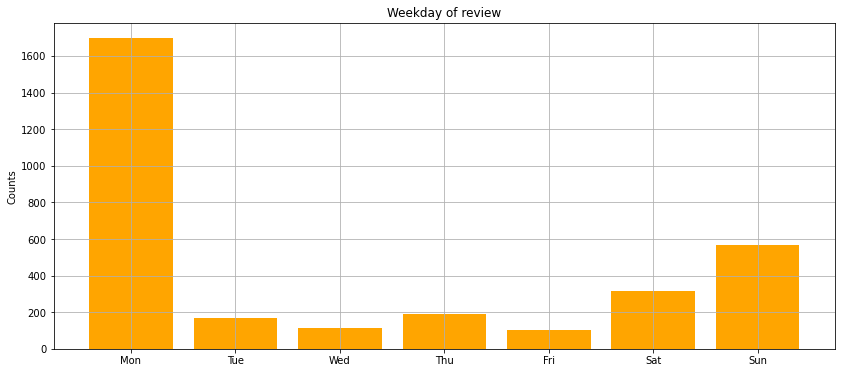

In [16]:
# Lets see how weekday analysis looks like
plt.rcParams['figure.figsize'] = (14,6)
df['weekday'].hist(bins=7,color='orange',range = (-.5,6.5),rwidth=.8)
plt.xticks(range(7),'Mon Tue Wed Thu Fri Sat Sun'.split());
plt.ylabel('Counts')
plt.title('Weekday of review')
plt.show()

* Surprisingly, maximum reviews posted on monday, 
* weekends come close to No 2 spot.

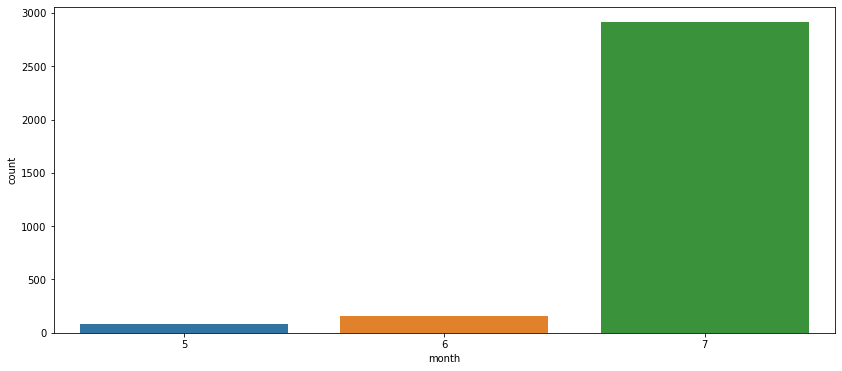

In [17]:
# Lets see how month analysis looks like
sns.countplot(x = 'month', data = df)

July has the maximum review submission 

In [18]:
# length of the review
lens = df['verified_reviews'].str.len()

fig = go.Figure()
fig.add_trace(
    go.Histogram(x=lens, xbins=dict(size=200))
    )
fig.update_layout(title='Length of reviews', 
                    xaxis_title="Length",
                    yaxis_title="# of reviews")
plotly.offline.iplot(fig)

* 2500 reviews have a length of (0 to 199)  
* 416 reviews have a length of (200 to 399)  
* Few review also have a length > 2500

Length of reviews Vs feedback = 0 or 1 : Analysis 1

In [19]:
#what is the length of the review based upon feedback
poslens = df[df['feedback']==1]['verified_reviews'].str.len()
neglens = df[df['feedback']==0]['verified_reviews'].str.len()
fig = go.Figure()
fig.add_trace(
    go.Histogram(x=poslens, xbins=dict(size=200), name='1'),
    )
fig.add_trace(
    go.Histogram(x=neglens, xbins=dict(size=200), name='0'),
    )
fig.update_layout(title='Length of reviews', 
                    xaxis_title="Length",
                    yaxis_title="# of reviews",)
plotly.offline.iplot(fig)


* For Feedback=1 : 2369 reviews have length between (0-199) 
* For Feedback=0 : only 163 reviews have length between (0-199) 
* Overall no of reviews are higher for feedback=1 than feedback=0 

Length of reviews Vs feedback = 0 or 1 : Analysis 2

In [20]:
#lets check the length of the reviews
df['length'] = df['verified_reviews'].apply(len)
df['length'].describe()

count    3150.000000
mean      132.049524
std       182.099952
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

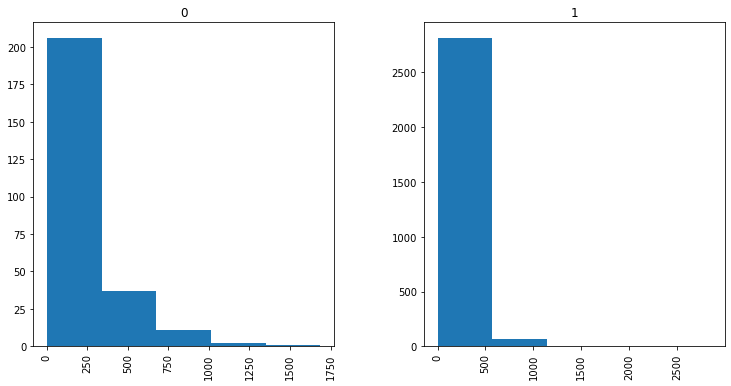

In [21]:
df.hist(column='length',by='feedback',bins=5,figsize=(12,6))
plt.show()

Above graphs confirms analysis 1 i.e. feedback=1 have way higher length of reviews(2500+) than feedback=0 (200+)   

Length of reviews Vs rating = 1 to 5 : (Analysis 1)

In [22]:
#what is the length of the reviews per +ve/-ve review?
lens1 = df[df['rating']==1]['verified_reviews'].str.len()
lens2 = df[df['rating']==2]['verified_reviews'].str.len()
lens3 = df[df['rating']==3]['verified_reviews'].str.len()
lens4 = df[df['rating']==4]['verified_reviews'].str.len()
lens5 = df[df['rating']==5]['verified_reviews'].str.len()

fig = go.Figure()
fig.add_trace(
    go.Histogram(x=lens1, xbins=dict(size=200), name='1'),
    )
fig.add_trace(
    go.Histogram(x=lens2, xbins=dict(size=200), name='2'),
    )
fig.add_trace(
    go.Histogram(x=lens3, xbins=dict(size=200), name='3'),
    )
fig.add_trace(
    go.Histogram(x=lens4, xbins=dict(size=200), name='4'),
    )
fig.add_trace(
    go.Histogram(x=lens5, xbins=dict(size=200), name='5'),
    )

fig.update_layout(title='Length of reviews', 
                    xaxis_title="Length",
                    yaxis_title="# of reviews",)
plotly.offline.iplot(fig)


rating 5 has highest 1955 reviews with length (0-199)

Length of reviews Vs rating = 1 to 5 : (Analysis 2)

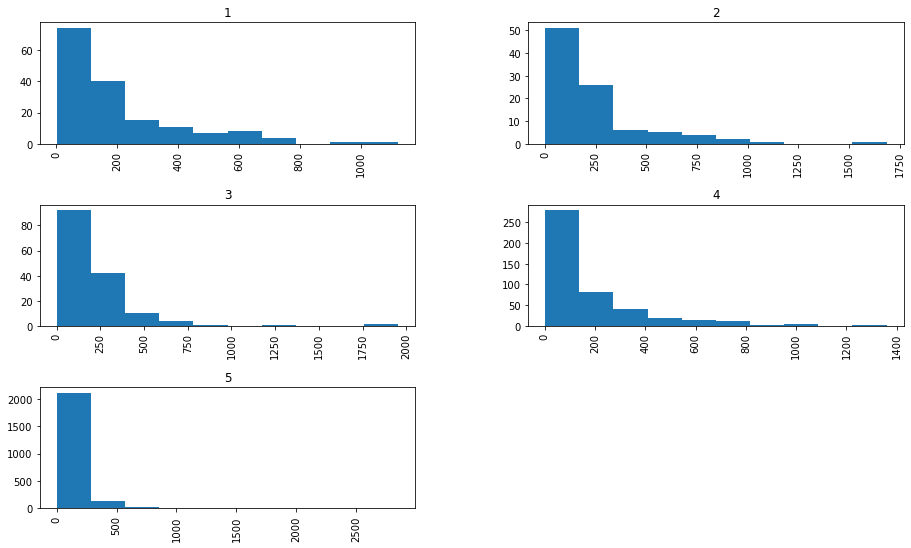

In [23]:
df.hist(column='length',by='rating',bins=10,figsize=(15,9))
plt.show()


Analysis 2 confirms analysis 1

Biveriate Analysis of variation Vs length with hue=feedback

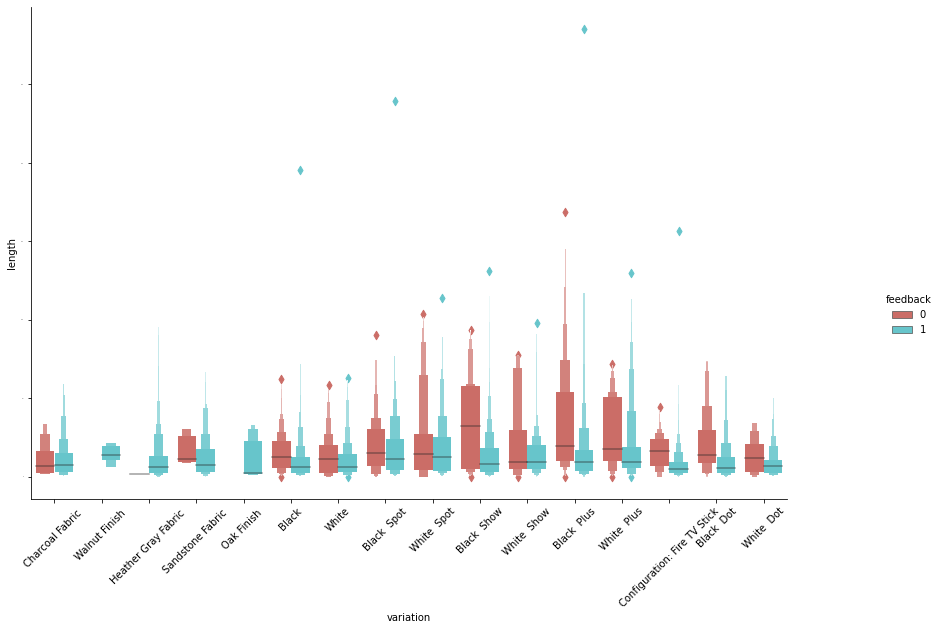

In [24]:
sns.catplot(data=df, x='variation', y='length', hue='feedback', kind='boxen', palette="hls");
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=1)
plt.xticks(rotation=45)
plt.show()

Biveriate Analysis of variation Vs length with hue=rating

* In general Length of reviews for feedback=0 is higher than feeback=1
* For Feedback=0 , length of review is higher for "black show", "Black Plus" & "White Plus"
* For "Walnut finish", "Oak finish" - feedback=0 is absent

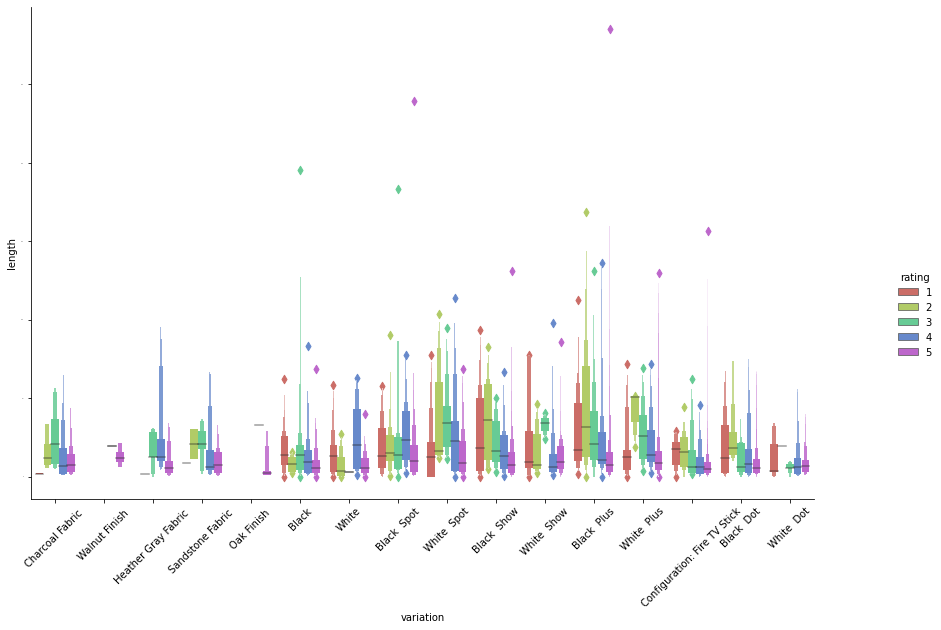

In [25]:
sns.catplot(data=df, x='variation', y='length', hue='rating', kind='boxen', palette="hls");
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=1)
plt.xticks(rotation=45)
plt.show()

* Length of reviews is highest for "Black plus " with rating=2 - indicates some issues with this product
* Walnut finish and Oak finish have got only rating 5 - Indicates that they might be the best product , also confirmed from variation Vs feedback analysis
* Maximum review length for rating 1 are for "Black show" & "Black plus" and "Black dot" indicating there may be issues with these products

Biveriate Analysis of rating Vs feedback 

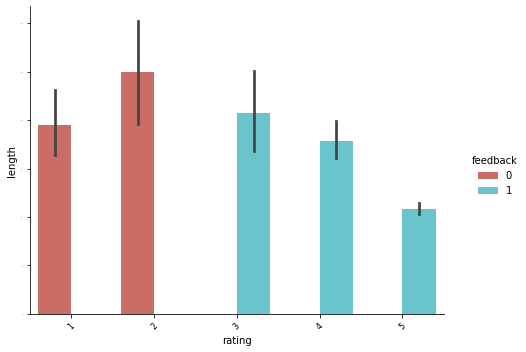

In [26]:
sns.catplot(data=df, x='rating', y='length', hue='feedback', kind='bar', palette="hls");
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.xticks(fontsize=8)
plt.yticks(fontsize=1)
plt.xticks(rotation=45)
plt.show()

* Above graph confirms that -
* Feedback=1 corresponds to rating 3,4,5 (Good,better, best)
* Feedback=0 corresponds to rating 1,2 (worst,bad)
* Average length of feedaback=0 is higher than feedback=1 (Dis-satidfied people are more likely to write more than satusfied people)
* Highly satisfied people (rating=5) write least as compared to others (rating 1-4)
* Products with rating = 2 have highest length of reviews

Explore length distibution V feedback using kde plots

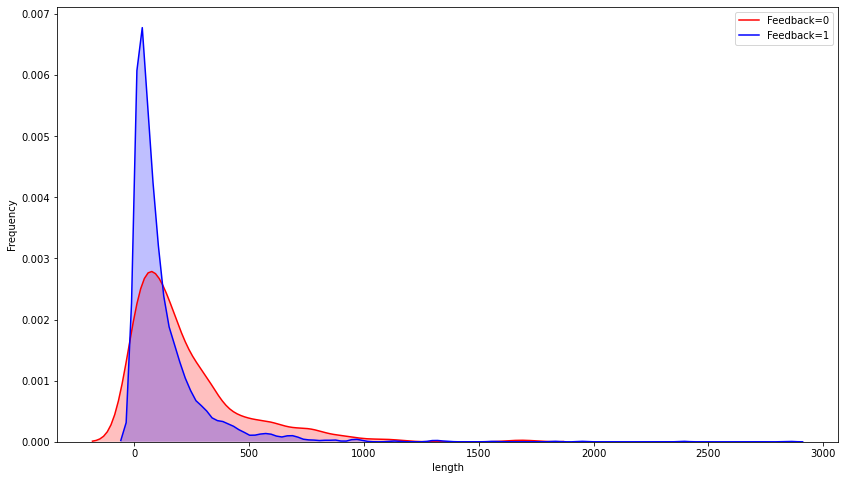

In [27]:
plt.figure(figsize=(14, 8))
g = sns.kdeplot(df["length"][(df["feedback"] == 0) & (df["length"].notnull())], color="Red", shade = True)
g = sns.kdeplot(df["length"][(df["feedback"] == 1) & (df["length"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("length")
g.set_ylabel("Frequency")
g = g.legend(["Feedback=0","Feedback=1"])

* Above kde plot confirms that 
* The length of reviews with feedback = 1 are less (0-300) i.e. max frequency
* The length of reviews with feedback = 0 are more (0-500) i.e. max frequency

Explore length distibution V rating using kde plots

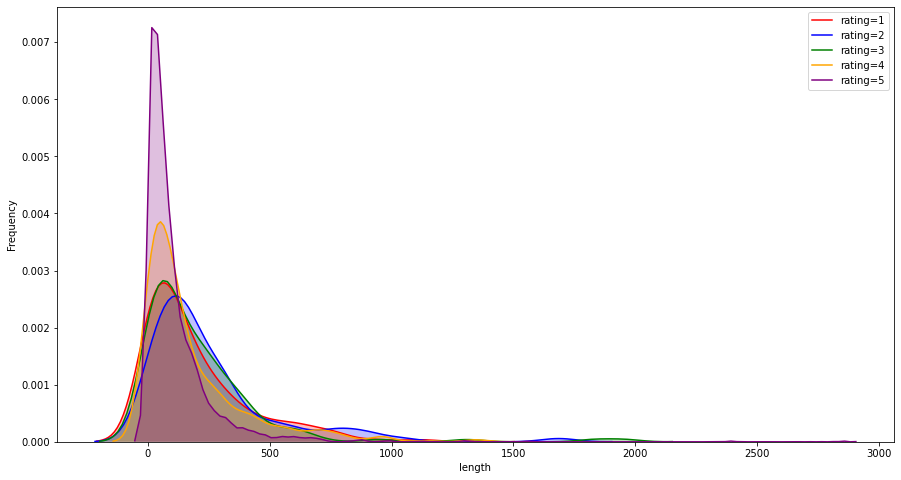

In [28]:
plt.figure(figsize=(15, 8))
g = sns.kdeplot(df["length"][(df["rating"] == 1) & (df["length"].notnull())], color="Red", shade = True)
g = sns.kdeplot(df["length"][(df["rating"] == 2) & (df["length"].notnull())], ax =g, color="Blue", shade= True)
g = sns.kdeplot(df["length"][(df["rating"] == 3) & (df["length"].notnull())], color="Green", shade = True)
g = sns.kdeplot(df["length"][(df["rating"] == 4) & (df["length"].notnull())], color="Orange", shade = True)
g = sns.kdeplot(df["length"][(df["rating"] == 5) & (df["length"].notnull())], color="Purple", shade = True)
g.set_xlabel("length")
g.set_ylabel("Frequency")
g = g.legend(["rating=1","rating=2","rating=3","rating=4","rating=5"])

* Above graphs confrms that
* rating=2 have highest length and rating=1 has minumum length

With the conclusion that
feedback=1 (rating 3,4 & 5) i.e. the best products and 
feedback=0 (rating 1 & 2) i.e. the worst products 

Lets do some more analysis on the variations Vs feedback and identify which is the best and worst product as per customer sentiments

catplot of variation Vs feedback

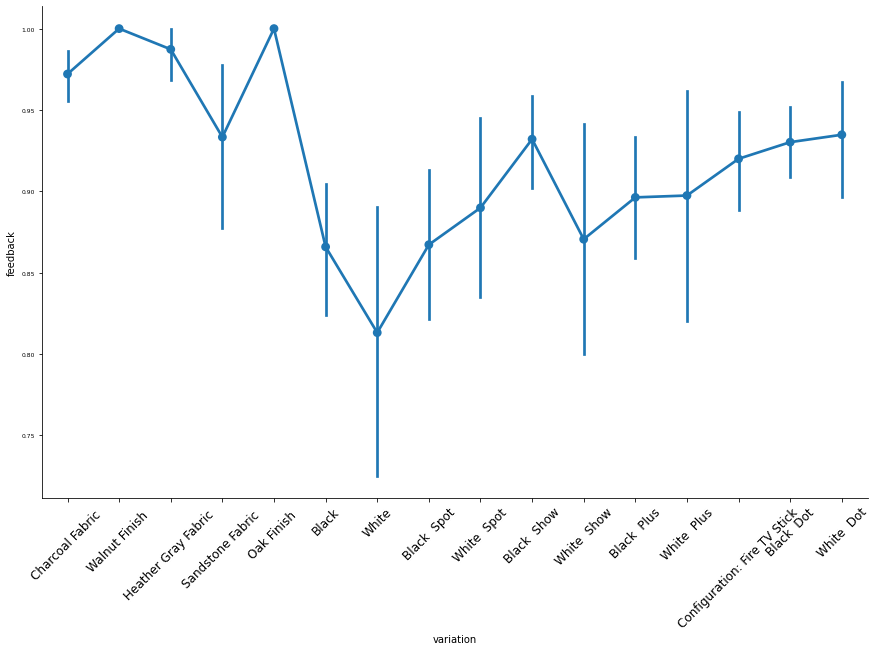

In [29]:
sns.catplot(x='variation',y='feedback',kind='point',data=df)
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=6)
plt.xticks(rotation=45)
plt.show()

* With respect to customer sentiments as per their feedback 0 or 1 :
* Walnut finish and oak finish are the top products
* Heather Grey Fabric comes close at No.2
* White is the worst product

Catplot variation+rating

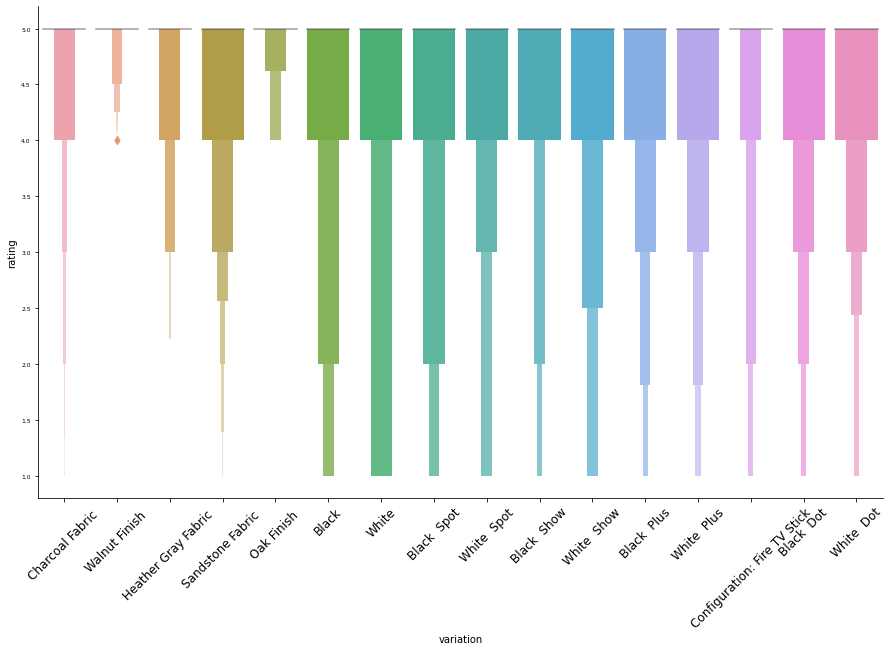

In [30]:
sns.catplot(x='variation',y='rating',kind='boxen',data=df)
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=6)
plt.xticks(rotation=45)
plt.show()


Above graph of variation Vs rating confirms our analysis about top and worst products
i.e. they have only 4 & 5 rating , others rating varies from 1 to 5 

Lets start cleaning the verified reviews

* verified reviews - Data cleaning & transformation

In [31]:
# Lets check the reviews again
df['verified_reviews'].head(5)

0                                        Love my Echo!
1                                            Loved it!
2    Sometimes while playing a game, you can answer...
3    I have had a lot of fun with this thing. My 4 ...
4                                                Music
Name: verified_reviews, dtype: object

In [32]:
#Step 1: transform to lowercase
df['review_lw'] = df['verified_reviews'].str.lower()
df[['verified_reviews','review_lw']].head(10)

,verified_reviews,review_lw
0,Love my Echo!,love my echo!
1,Loved it!,loved it!
2,"Sometimes while playing a game, you can answer...","sometimes while playing a game, you can answer..."
3,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing. my 4 ...
4,Music,music
5,I received the echo as a gift. I needed anothe...,i received the echo as a gift. i needed anothe...
6,"Without having a cellphone, I cannot use many ...","without having a cellphone, i cannot use many ..."
7,I think this is the 5th one I've purchased. I'...,i think this is the 5th one i've purchased. i'...
8,looks great,looks great
9,Love it! I’ve listened to songs I haven’t hear...,love it! i’ve listened to songs i haven’t hear...


In [33]:
#Step 2: Removing HTML Tags
df['review_lw'] = df['review_lw'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text().strip())

df[['verified_reviews','review_lw']].head(10)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:398: UserWarning:

"https://www.amazon.com/dp/b073sqyxtw/ref=cm_cr_ryp_prd_ttl_sol_18" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.



,verified_reviews,review_lw
0,Love my Echo!,love my echo!
1,Loved it!,loved it!
2,"Sometimes while playing a game, you can answer...","sometimes while playing a game, you can answer..."
3,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing. my 4 ...
4,Music,music
5,I received the echo as a gift. I needed anothe...,i received the echo as a gift. i needed anothe...
6,"Without having a cellphone, I cannot use many ...","without having a cellphone, i cannot use many ..."
7,I think this is the 5th one I've purchased. I'...,i think this is the 5th one i've purchased. i'...
8,looks great,looks great
9,Love it! I’ve listened to songs I haven’t hear...,love it! i’ve listened to songs i haven’t hear...


In [34]:
#Step 3: remove stopwords 'n punctuation
sw = stopwords.words('english')

In [35]:
def transform_text(s):
    
    # remove html
    html=re.compile(r'<.*?>')
    s = html.sub(r'',s)
    
    # remove numbers
    s = re.sub(r'\d+', '', s)
    
    # remove punctuation
    # remove stopwords
    tokens = nltk.word_tokenize(s)
    
    new_string = []
    for w in tokens:
        # remove words with len = 2 AND stopwords
        if len(w) > 2 and w not in sw:
            new_string.append(w)
 
    s = ' '.join(new_string)
    s = s.strip()

    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    
    return s.strip()


In [36]:
df['review_sw'] = df['review_lw'].apply(transform_text)
df[['verified_reviews','review_lw', 'review_sw']].head(10)

,verified_reviews,review_lw,review_sw
0,Love my Echo!,love my echo!,love echo
1,Loved it!,loved it!,loved
2,"Sometimes while playing a game, you can answer...","sometimes while playing a game, you can answer...",sometimes playing game answer question correct...
3,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing. my 4 ...,lot fun thing old learns dinosaurs control lig...
4,Music,music,music
5,I received the echo as a gift. I needed anothe...,i received the echo as a gift. i needed anothe...,received echo gift needed another bluetooth so...
6,"Without having a cellphone, I cannot use many ...","without having a cellphone, i cannot use many ...",without cellphone use many features ipad see u...
7,I think this is the 5th one I've purchased. I'...,i think this is the 5th one i've purchased. i'...,think one ve purchased working getting one eve...
8,looks great,looks great,looks great
9,Love it! I’ve listened to songs I haven’t hear...,love it! i’ve listened to songs i haven’t hear...,love listened songs heard since childhood get ...


In [37]:
#Step 4: lemmatizer

lemmatizer = WordNetLemmatizer() 

In [38]:
def lemmatizer_text(s):
    tokens = nltk.word_tokenize(s)
    
    new_string = []
    for w in tokens:
        lem = lemmatizer.lemmatize(w, pos="v")
        # exclude if lenght of lemma is smaller than 2
        if len(lem) > 2:
            new_string.append(lem)
    
    s = ' '.join(new_string)
    return s.strip()

In [39]:
df['review_lm'] = df['review_sw'].apply(lemmatizer_text)
df[['verified_reviews','review_lw', 'review_sw', 'review_lm']].head(20)

,verified_reviews,review_lw,review_sw,review_lm
0,Love my Echo!,love my echo!,love echo,love echo
1,Loved it!,loved it!,loved,love
2,"Sometimes while playing a game, you can answer...","sometimes while playing a game, you can answer...",sometimes playing game answer question correct...,sometimes play game answer question correctly ...
3,I have had a lot of fun with this thing. My 4 ...,i have had a lot of fun with this thing. my 4 ...,lot fun thing old learns dinosaurs control lig...,lot fun thing old learn dinosaurs control ligh...
4,Music,music,music,music
5,I received the echo as a gift. I needed anothe...,i received the echo as a gift. i needed anothe...,received echo gift needed another bluetooth so...,receive echo gift need another bluetooth somet...
6,"Without having a cellphone, I cannot use many ...","without having a cellphone, i cannot use many ...",without cellphone use many features ipad see u...,without cellphone use many feature ipad see us...
7,I think this is the 5th one I've purchased. I'...,i think this is the 5th one i've purchased. i'...,think one ve purchased working getting one eve...,think one purchase work get one every room hou...
8,looks great,looks great,looks great,look great
9,Love it! I’ve listened to songs I haven’t hear...,love it! i’ve listened to songs i haven’t hear...,love listened songs heard since childhood get ...,love listen songs hear since childhood get new...


In [40]:
#Step 5: Removing Rare Words
text = ' '.join(df['review_lm'])
len(text)

241100

In [41]:
# Creating Frequency
text_series = pd.Series(text.split())
freq_comm = text_series.value_counts()
freq_comm


love          1060
echo           858
great          720
use            681
work           648
              ... 
accessable       1
iove             1
typically        1
approach         1
lcd              1
Length: 3234, dtype: int64

Lets identify words which have frequency of 1 and categorize them as rare words for deletion

In [42]:
rare_words = freq_comm[-1258:-1]
'rattlecrackle' in rare_words

True

Print rare words

In [43]:
rare_words

inspire       1
tone          1
spouse        1
soundgood     1
suitable      1
             ..
stubborn      1
accessable    1
iove          1
typically     1
approach      1
Length: 1257, dtype: int64

In [44]:
# Removing 1258 rare occuring words 
df['review_lm'] = df['review_lm'].apply(lambda x: ' '.join([word for word in x.split() if word not in rare_words]))
df['review_lm'].sample(5)

1295                                       love echo spot
2434                                easy set work perfect
3094                  amaze product still learnimg things
2600                                         need smarter
2506    love alexa around house favorite feature timer...
Name: review_lm, dtype: object

In [45]:
text = ' '.join(df['review_lm'])
len(text)

230619

So we removed 241100 - 230614 = approx 10k characters

Text cleaning completed

Lets see word cloud for feedback=1 (i.e. Positive reviews)

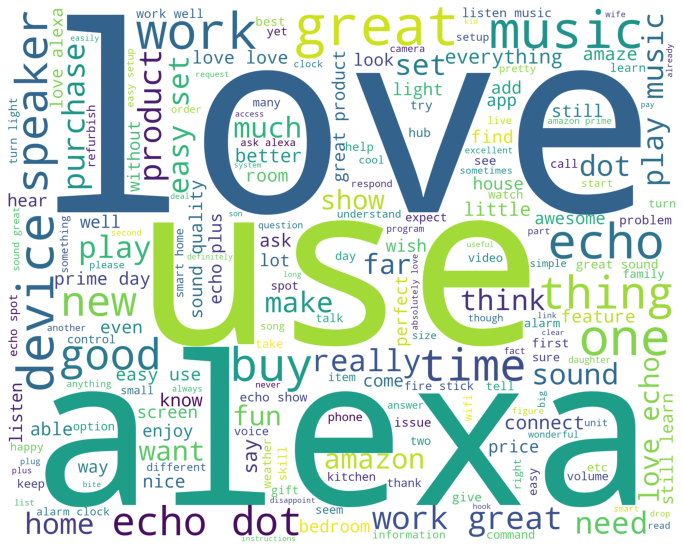

In [46]:
df_pos = df[df['feedback']==1]['review_lm']

wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()


We can see lots of positive words (i.e. good, perfect, easy use, enjoy etc) with feedback=1

Lets see word cloud for feedback=0 (i.e. Negative reviews)

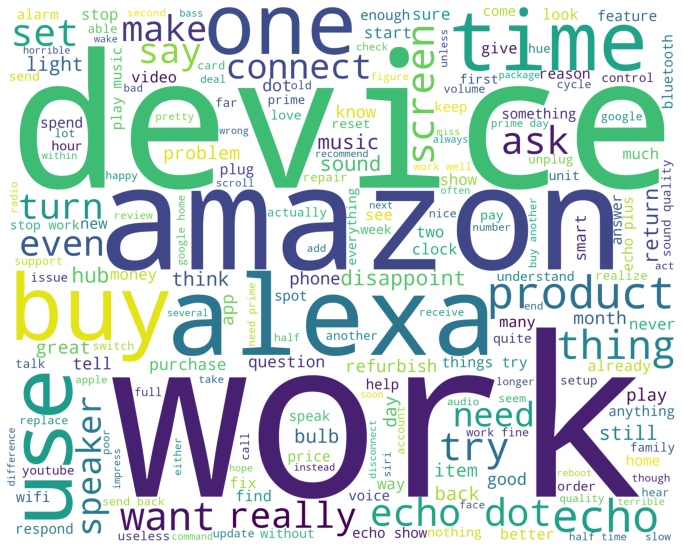

In [47]:
df_neg = df[df['feedback']==0]['review_lm']

wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

We can see few negative words (i.e. bad, disappoint, problem, stop,replace, return, repair, never etc) with feedback=0

Plot  N-grams 

In [48]:
def plot_ngram(sentiment, n):
    print("sentiment",sentiment)
    temp_df = df[df['feedback'] == sentiment]
    
    word_vectorizer = CountVectorizer(ngram_range=(n, n), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(temp_df['review_lm'])
    
    frequencies = sum(sparse_matrix).toarray()[0]
    
    return pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])\
            .sort_values(by='frequency', ascending=False) \
            .reset_index() \
            .head(10)

* Data is cleaned and ready for Model Building ...
* ****so Lets DO It

In [49]:
# For Feedback=1
plot_ngram(1, 1)

sentiment 1


,index,frequency
0,love,1051
1,echo,766
2,great,702
3,use,633
4,alexa,572
5,work,546
6,music,505
7,like,483
8,get,429
9,sound,390


In [50]:
# For Feedback=0
plot_ngram(0, 1)

sentiment 0


,index,frequency
0,work,102
1,echo,92
2,get,68
3,amazon,60
4,would,58
5,buy,57
6,device,54
7,alexa,54
8,time,50
9,use,48


calculate +ve Vs -ve review count

In [51]:
#Feedback=1 (i.e. +ve)
df[df['feedback']== 1]['review_lm'].count()

2893

In [52]:
#Feedback=0 (i.e. -ve)
df[df['feedback']== 0]['review_lm'].count()

257

* Total +ve reviews : 2893 and 
* Total -ve reviews : 257 
* We will split them equally into train and test datasets for model building 

Train and test dataset

* Feeedback=1 : Total 2893
* we can use the first 2025(70%) for training and 868(30%) remaining for testing
* i.e. 2893=2025+868
* 
* Feeedback=0 : Total 257
* we can use the first 180(70%) for training and 77(30%) remaining for testing
* i.e. 257=180+77

In [53]:
# Train dataset
pos_train = df[df['feedback']==1][['review_lm', 'feedback']].head(2025)
neg_train = df[df['feedback']==0][['review_lm', 'feedback']].head(180)


# Test dataset
pos_test = df[df['feedback']==1][['review_lm', 'feedback']].tail(868)
neg_test = df[df['feedback']==0][['review_lm', 'feedback']].tail(77)

In [54]:
# put all toghether 
train_df = pd.concat([pos_train, neg_train]).sample(frac = 1).reset_index(drop=True)
test_df = pd.concat([pos_test, neg_test]).sample(frac = 1).reset_index(drop=True)

In [55]:
train_df.head()

,review_lm,feedback
0,,0
1,already echo dot echo even better fuller sound...,1
2,second one put one kitchen recipes,1
3,use last weeks like children also like alexa b...,1
4,love much,1


In [56]:
test_df.head()

,review_lm,feedback
0,love,1
1,addict thing,1
2,suppose great product,1
3,love echo,1
4,old amazon fire stick keep crash use sling buy...,0


In [57]:
X_train = train_df['review_lm']
X_test  = test_df['review_lm']
y_train = train_df['feedback']
y_test  = test_df['feedback']

Model Building starts

Lets try Bag of words Model with binary=True

In [58]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(X_train)
X_train_onehot = vectorizer.transform(X_train)
X_test_onehot = vectorizer.transform(X_test)

#print shape post encoding 
print(X_train_onehot.shape)
print(X_test_onehot.shape)

(2205, 1777)
(945, 1777)


In [59]:
#Let's have a look at 10 words from the word vocabulary 
#with their corresponding indices in the vocabulary.
word_dict = vectorizer.vocabulary_
print({k: word_dict[k] for k in list(word_dict)[:20]})


{'already': 57, 'echo': 490, 'dot': 472, 'even': 535, 'better': 170, 'fuller': 650, 'sound': 1460, 'also': 58, 'setup': 1392, 'let': 895, 'phone': 1146, 'call': 232, 'make': 940, 'contact': 334, 'list': 908, 'great': 697, 'second': 1370, 'one': 1072, 'put': 1242, 'kitchen': 860}


In [60]:
# Generic function for model building
def fit_and_test(classifier, X_train, y_train, X_test, y_test, only_return_accuracy=False):
  classifier.fit(X_train, y_train)
  y_hat = classifier.predict(X_test)
  print('accuracy:', accuracy_score(y_test, y_hat))
  if not only_return_accuracy:
    print('f1_score:', f1_score(y_test, y_hat))

In [61]:
#Logistic Regression

#grid search over regularisation hyperparameter 'c'
for c in [0.01, 0.02, 0.05, 0.25, 0.5, 0.75, 1,]:
  lr = LogisticRegression(C=c, max_iter=1000) # 92.91%
  print (f'At C = {c}:-', end=' ')
  fit_and_test(lr, X_train_onehot, y_train, X_test_onehot, y_test, True)

At C = 0.01:- accuracy: 0.9185185185185185
At C = 0.02:- accuracy: 0.9185185185185185
At C = 0.05:- accuracy: 0.9185185185185185
At C = 0.25:- accuracy: 0.9227513227513228
At C = 0.5:- accuracy: 0.9227513227513228
At C = 0.75:- accuracy: 0.926984126984127
At C = 1:- accuracy: 0.9301587301587302


Lets run Logistic Regression with C=1 for which we got highest accuracy

In [62]:
#Make an instance of the model
logistic = LogisticRegression(C=1,max_iter=10000)
#fitting the values for x and y
logistic.fit(X_train_onehot,y_train)

LogisticRegression(C=1, max_iter=10000)

In [63]:
#predictions from test data
prediction = logistic.predict(X_test_onehot)

Text(332.52000000000004, 0.5, 'Predicted')

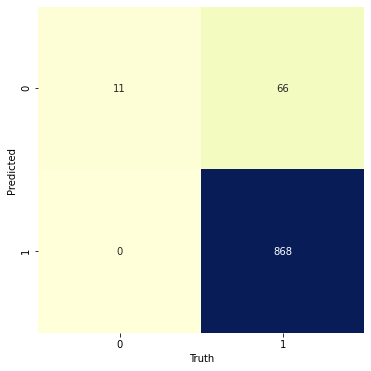

In [64]:
###### confusion matrix  starts ######
from sklearn.metrics import accuracy_score, confusion_matrix
cm_lgr1 = confusion_matrix(y_test,prediction) 
names = np.unique(prediction)
sns.heatmap(cm_lgr1, square=True, annot=True, cbar=False,xticklabels=names, yticklabels=names, cmap="YlGnBu" ,fmt='g')
plt.xlabel('Truth')
plt.ylabel('Predicted')

###### Confusion matrix ends ########

In [65]:
#calculating the accuracy
accuracy_score = accuracy_score(y_test,prediction)
print("Accuracy of  Logistic Regression :",accuracy_score)

Accuracy of  Logistic Regression : 0.9301587301587302


Simple Logistic Regression achieved 93% accuracy for C=1 (Only 67 samples out of 945 were misclassified by the Model)

Print n-grams and frequency

In [66]:
################ Print n-grams and frequency starts #################
vectorizer = CountVectorizer()
vect_texts = vectorizer.fit_transform(list(df['review_lm']))

all_ngrams = vectorizer.get_feature_names()
#print(all_ngrams[:5])
num_ngrams = min(50, len(all_ngrams))
all_counts = vect_texts.sum(axis=0).tolist()[0]

all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]

idx = np.arange(num_ngrams)

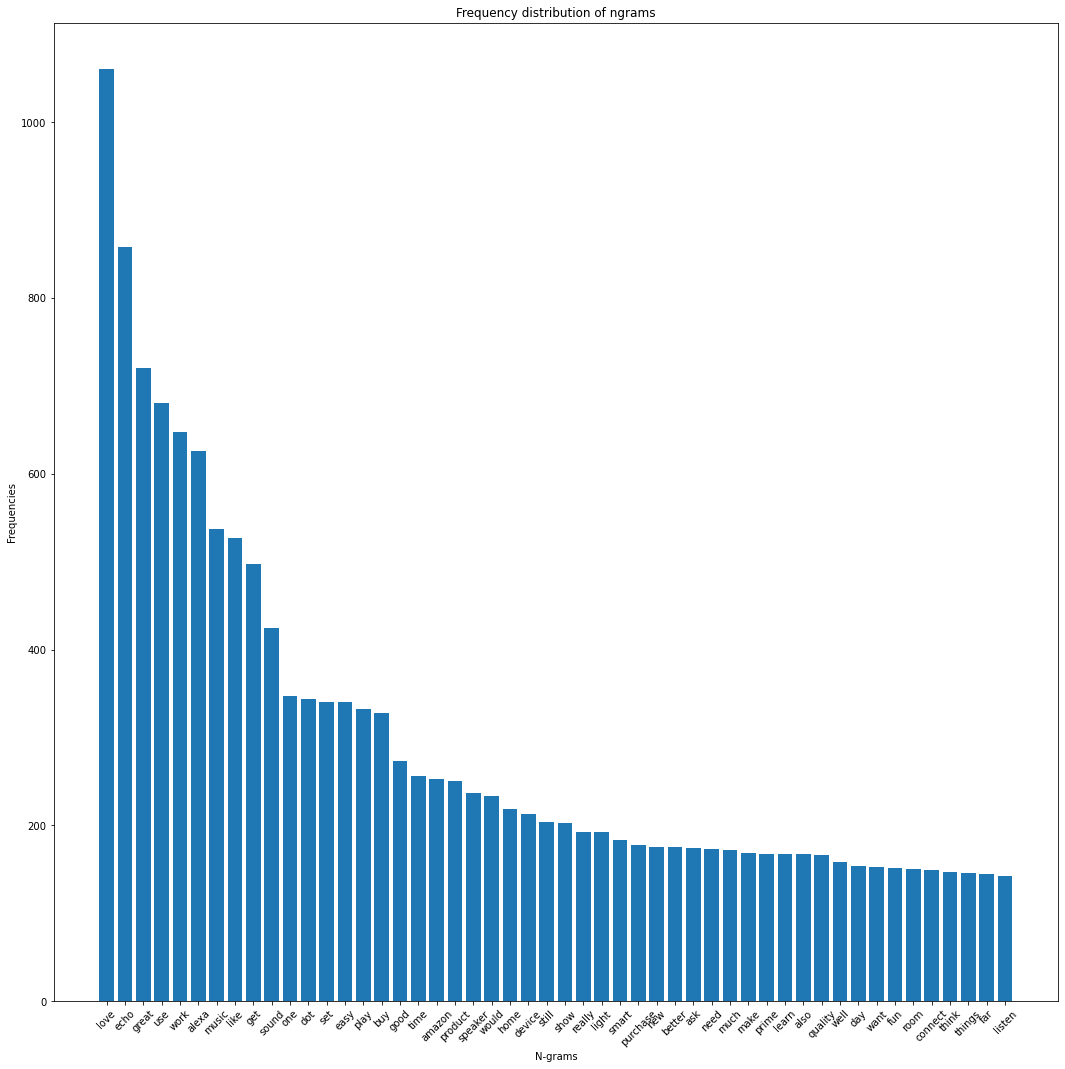

In [67]:
# Let's plot a frequency distribution plot for the most seen words
plt.figure(figsize=(18, 18))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

How about trying Keras 

Keras with batch normalisation with mode=count

In [68]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix

In [69]:
# create the tokenizer
tokenizer = Tokenizer()

# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)
# encode training data set
Xtrain = tokenizer.texts_to_matrix(X_train, mode='count')

# encode training data set
Xtest = tokenizer.texts_to_matrix(X_test, mode='count')

n_words1 = Xtest.shape[1]

print("n_words1", n_words1)

n_words1 1780


In [70]:
model = tf.keras.models.Sequential([
       
    tf.keras.layers.Dense(256, input_shape=(n_words1,), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
          
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [71]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['acc'])

#print(model.summary())

In [72]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]


history = model.fit(Xtrain, y_train,
                    epochs=20,
                    validation_data=(Xtest, y_test,),
                    verbose=1,
                    callbacks=callbacks,
                   )

Epoch 1/20
69/69 [==============================] - 1s 10ms/step - loss: 0.9597 - acc: 0.5288 - val_loss: 0.7170 - val_acc: 0.1989
Epoch 2/20
69/69 [==============================] - 0s 6ms/step - loss: 0.8788 - acc: 0.5447 - val_loss: 0.7170 - val_acc: 0.2878
Epoch 3/20
69/69 [==============================] - 0s 6ms/step - loss: 0.8045 - acc: 0.5977 - val_loss: 0.6936 - val_acc: 0.4889
Epoch 4/20
69/69 [==============================] - 0s 6ms/step - loss: 0.7490 - acc: 0.6259 - val_loss: 0.6619 - val_acc: 0.6899
Epoch 5/20
69/69 [==============================] - 0s 6ms/step - loss: 0.6824 - acc: 0.6499 - val_loss: 0.6143 - val_acc: 0.7968
Epoch 6/20
69/69 [==============================] - 0s 6ms/step - loss: 0.6516 - acc: 0.6667 - val_loss: 0.5710 - val_acc: 0.8243
Epoch 7/20
69/69 [==============================] - 0s 6ms/step - loss: 0.5787 - acc: 0.7202 - val_loss: 0.5271 - val_acc: 0.8476
Epoch 8/20
69/69 [==============================] - 0s 6ms/step - loss: 0.5530 - acc: 0.7

Lets make the prediction

In [73]:
# Function to make predictions 
def prediction(X_test, clf_object): 
  
    y_pred = clf_object.predict(X_test) 
    return y_pred

In [74]:
predictions_keras = prediction(Xtest, model) 

In [75]:
pred_ann = [ 1 if y>=0.5 else 0 for y in predictions_keras]

In [76]:
#calculating the accuracy
accuracy_score = accuracy_score(y_test,pred_ann)
print("Accuracy score with Keras:",accuracy_score)

Accuracy score with Keras: 0.9238095238095239


Lets plot training/validation accuracy graphs and loss graphs

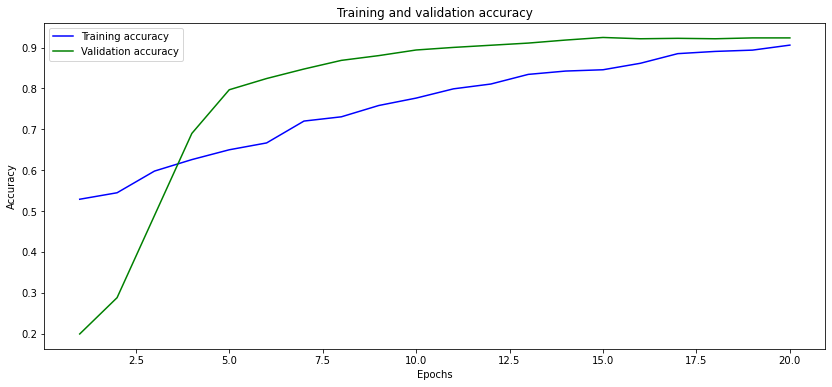

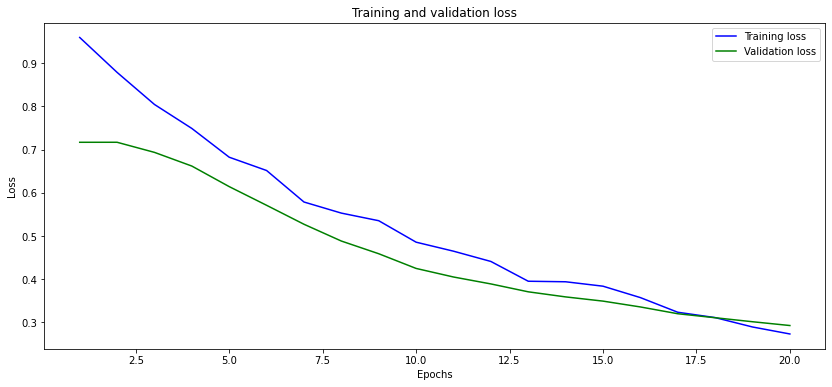

In [77]:
def plot_history(history):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1,len(accuracy) + 1)
    
    # Plot accuracy  
    plt.figure(1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.figure(2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

Time to print Confusion matrix

Text(332.52000000000004, 0.5, 'Predicted')

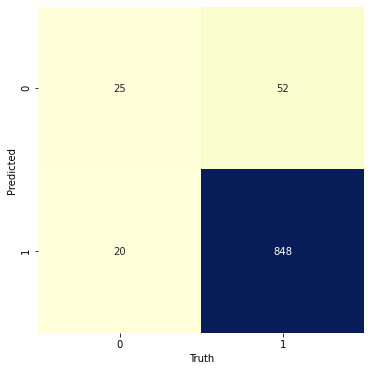

In [78]:
###### confusion matrix  starts ######
from sklearn.metrics import accuracy_score, confusion_matrix
cm_ann = confusion_matrix(y_test,pred_ann) 
names = np.unique(pred_ann)
sns.heatmap(cm_ann, square=True, annot=True, cbar=False,xticklabels=names, yticklabels=names, cmap="YlGnBu" ,fmt='g')
plt.xlabel('Truth')
plt.ylabel('Predicted')
###### Confusion matrix ends ########

* > **Keras with Tokenizer API produced 93.33% accuracy and only 63 samples were misclassified **

Lets try Embedding Layer with CNN

In [79]:
# create the tokenizer
tokenizer = Tokenizer()

# fit the tokenizer on the train documents
tokenizer.fit_on_texts(X_train)

In [80]:
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(X_train)
# pad sequences
max_length = max([len(s.split()) for s in X_train])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [81]:
# fit the tokenizer on the test documents
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(X_test)
# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [82]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size = ",vocab_size)

vocab_size =  1780


In [83]:
# define model

model = Sequential()

model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 230, 100)          178000    
_________________________________________________________________
conv1d (Conv1D)              (None, 223, 32)           25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 111, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3552)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                35530     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 239,173
Trainable params: 239,173
Non-trainable params: 0
________________________________________________

In [84]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, y_train, epochs=10, verbose=1)

Epoch 1/10
69/69 [==============================] - 2s 27ms/step - loss: 0.3285 - accuracy: 0.9057
Epoch 2/10
69/69 [==============================] - 2s 27ms/step - loss: 0.2646 - accuracy: 0.9184
Epoch 3/10
69/69 [==============================] - 2s 27ms/step - loss: 0.1927 - accuracy: 0.9184
Epoch 4/10
69/69 [==============================] - 2s 27ms/step - loss: 0.1224 - accuracy: 0.9370
Epoch 5/10
69/69 [==============================] - 2s 26ms/step - loss: 0.0920 - accuracy: 0.9746
Epoch 6/10
69/69 [==============================] - 2s 28ms/step - loss: 0.0794 - accuracy: 0.9814
Epoch 7/10
69/69 [==============================] - 2s 27ms/step - loss: 0.0738 - accuracy: 0.9868
Epoch 8/10
69/69 [==============================] - 2s 27ms/step - loss: 0.0702 - accuracy: 0.9891
Epoch 9/10
69/69 [==============================] - 2s 26ms/step - loss: 0.0685 - accuracy: 0.9873
Epoch 10/10
69/69 [==============================] - 2s 26ms/step - loss: 0.0667 - accuracy: 0.9900


In [85]:
# evaluate
loss, acc = model.evaluate(Xtest, y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 93.015873


Now lets try with Glove embedding i.e. using glove6b100d.txt 

# We achieved 92.91% accuracy with Embedding layer along with CNN

Now lets try Deep Learning algorithm with Word embeddigns from GloVe: Global Vectors for Word Representation

In [86]:
# load embedding as a dict
def load_embedding_glove(filename):
    # load embedding into memory, no need to skip first line
    file = open(filename,'r', encoding='utf-8')
    lines = file.readlines()
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

In [87]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix_glove(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

In [88]:
# load embedding from file
raw_embedding = load_embedding_glove('../input/glove6b100dtxt/glove.6B.100d.txt')


In [89]:
# get vectors in the right order
embedding_vectors = get_weight_matrix_glove(raw_embedding, tokenizer.word_index)


In [90]:
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=True)

In [91]:
# define model

model = Sequential()

model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 230, 100)          178000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 226, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 113, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14464)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 14465     
Total params: 256,593
Trainable params: 256,593
Non-trainable params: 0
_________________________________________________________________
None


In [92]:
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
# fit network
model.fit(Xtrain, y_train, epochs=10, verbose=2)

Epoch 1/10
69/69 - 3s - loss: 0.3170 - accuracy: 0.9111
Epoch 2/10
69/69 - 3s - loss: 0.2109 - accuracy: 0.9270
Epoch 3/10
69/69 - 3s - loss: 0.1494 - accuracy: 0.9429
Epoch 4/10
69/69 - 3s - loss: 0.0948 - accuracy: 0.9655
Epoch 5/10
69/69 - 3s - loss: 0.0639 - accuracy: 0.9791
Epoch 6/10
69/69 - 3s - loss: 0.0459 - accuracy: 0.9828
Epoch 7/10
69/69 - 3s - loss: 0.0362 - accuracy: 0.9873
Epoch 8/10
69/69 - 3s - loss: 0.0304 - accuracy: 0.9891
Epoch 9/10
69/69 - 3s - loss: 0.0260 - accuracy: 0.9909
Epoch 10/10
69/69 - 3s - loss: 0.0239 - accuracy: 0.9927


In [94]:
# evaluate
loss, acc = model.evaluate(Xtest, y_test, verbose=1)
print('Test Accuracy: %f' % (acc*100))

30/30 [==============================] - 0s 11ms/step - loss: 0.3002 - accuracy: 0.9312
Test Accuracy: 93.121696


# Wow !! We got 93% Accuracy with Word embeddigns from GloVe: Global Vectors for Word Representation

So we have solved this problem with 4 methods :

1. Simple Logistic regression i.e. classical Method - 92% Accuracy
1. Artificial Neural Networks - Multiplayer Perceptron - 93% Accuracy
1. Artificial Neural Networks - Word Embeddings along with CNN (Convolutional Neural Networks)  - 93% Accuracy
1. Artificial Neural Networks - Word Embeddings along With Glove : Global Vectors for Word Representation - 93% Accuracy

# Isn't it Amazing !!

Below are the links to my other Kernel

1. Heart Diesese Prediction (88.52% with simple KNN) - https://www.kaggle.com/rahulpednekar/heart-88-52-accuracy-with-simple-knn 
2. Loan Prediction (85.36% Accuracy) - https://www.kaggle.com/rahulpednekar/loan-prediction-85-36-with-logistic-regression 
3. Heart Failure Prediction (95% Accuracy)-  https://www.kaggle.com/rahulpednekar/heart-failure-prediction-95-accuracy

# If you have liked my Kernel, PLEASE UPVOTE

Special thanks to https://machinelearningmastery.com/ for the tutorial on Word Embeddings